# 01. 数据读取与预处理

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# tripdata = pd.read_csv('green_tripdata_2015-04.csv')
tripdata = pd.read_parquet('yellow_tripdata_2024-01.parquet')


In [ ]:
df = tripdata.copy()
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [ ]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee'],
      dtype='object')

In [ ]:
df.isnull().sum()


,0
VendorID,0
tpep_pickup_datetime,0
tpep_dropoff_datetime,0
passenger_count,140162
trip_distance,0
RatecodeID,140162
store_and_fwd_flag,140162
PULocationID,0
DOLocationID,0
payment_type,0


# 时间格式处理

In [ ]:
df["pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

# 数据填充和删除

In [ ]:
df["tpep_pickup_datetime"].min(), df["tpep_pickup_datetime"].max()

(Timestamp('2002-12-31 22:59:39'), Timestamp('2024-02-01 00:01:15'))

In [ ]:
print(f"Original data rows: {len(df)}")

# Filter out data before January 1, 2024
start_date = pd.Timestamp('2024-01-01')
df= df[df['tpep_pickup_datetime'] >= start_date].copy()

print(f"Cleaned data rows: {len(df)}")
print(f"Removed abnormal rows: {len(df) - len(df)}")

# Verify time range
df["tpep_pickup_datetime"].min(), df["tpep_pickup_datetime"].max()

Original data rows: 2964624
Cleaned data rows: 2964609
Removed abnormal rows: 0


(Timestamp('2024-01-01 00:00:00'), Timestamp('2024-02-01 00:01:15'))

In [ ]:
# Fill NaN with default values
df["passenger_count"] = df["passenger_count"].fillna(1)   # neutral value
df["congestion_surcharge"] = df["congestion_surcharge"].fillna(0)
df["Airport_fee"] = df["Airport_fee"].fillna(0)

# Drop columns that are useless for forecasting
df = df.drop(columns=["RatecodeID", "store_and_fwd_flag"])

# 异常值检测和清理

In [ ]:
df = df[(df["trip_distance"] > 0) & (df["trip_distance"] <= 50)]

In [ ]:
df["duration_min"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60
df = df[(df["duration_min"] > 1) & (df["duration_min"] <= 180)]

In [ ]:
df["speed_mph"] = df["trip_distance"] / (df["duration_min"] / 60)

df = df[(df["speed_mph"] > 1) & (df["speed_mph"] <= 80)]

In [ ]:
df = df[df["dropoff_datetime"] >= df["pickup_datetime"]]


In [ ]:
# 检查负数
fare_cols = ["fare_amount","extra","mta_tax","tip_amount",
             "tolls_amount","improvement_surcharge","total_amount"]

for col in fare_cols:
    df = df[df[col] >= 0]


In [ ]:
df = df[df["total_amount"] >= df["fare_amount"]]

# 查看清洗后数据

In [ ]:
df = df[[
    "pickup_datetime", "dropoff_datetime",
    "PULocationID", "DOLocationID",
    "passenger_count", "trip_distance",
    "duration_min", "speed_mph",
    "payment_type",
    "fare_amount","extra","mta_tax","tip_amount",
    "tolls_amount","improvement_surcharge",
    "congestion_surcharge","Airport_fee",
    "total_amount"
]].reset_index(drop=True)


In [ ]:
print("Original size:", tripdata.shape)
print("Cleaned size:", df.shape)
print("Removed rows:", tripdata.shape[0] - df.shape[0])


Original size: (2964624, 19)
Cleaned size: (2857016, 18)
Removed rows: 107608


# Time feature EDA

In [ ]:
df["hour"] = df["pickup_datetime"].dt.hour
df["weekday"] = df["pickup_datetime"].dt.dayofweek   # 0=Mon
df["day"] = df["pickup_datetime"].dt.day
df["month"] = df["pickup_datetime"].dt.month


Hourly Demand

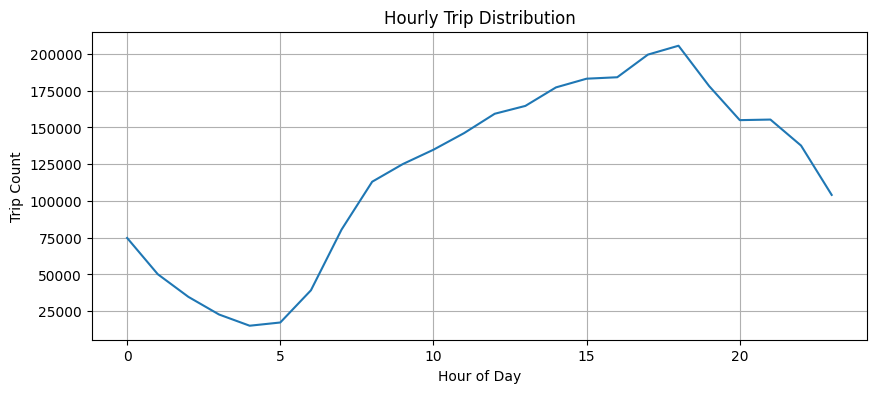

In [ ]:
hourly_counts = df.groupby("hour").size()

plt.figure(figsize=(10,4))
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values)
plt.title("Hourly Trip Distribution")
plt.xlabel("Hour of Day")
plt.ylabel("Trip Count")
plt.grid(True)
plt.show()


Weekly Demand

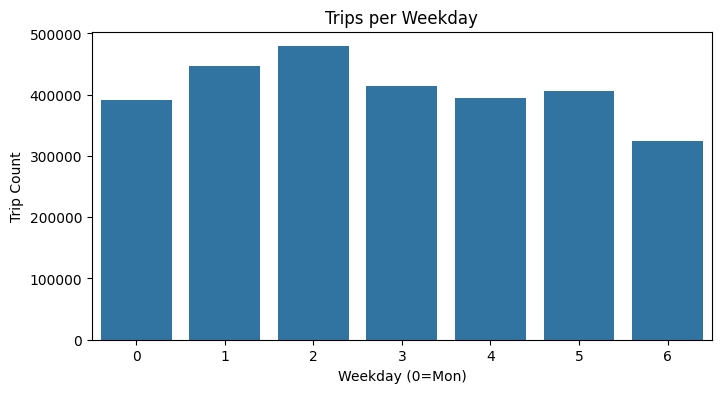

In [ ]:
weekday_counts = df.groupby("weekday").size()

plt.figure(figsize=(8,4))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values)
plt.title("Trips per Weekday")
plt.xlabel("Weekday (0=Mon)")
plt.ylabel("Trip Count")
plt.show()

# 空间特征EDA

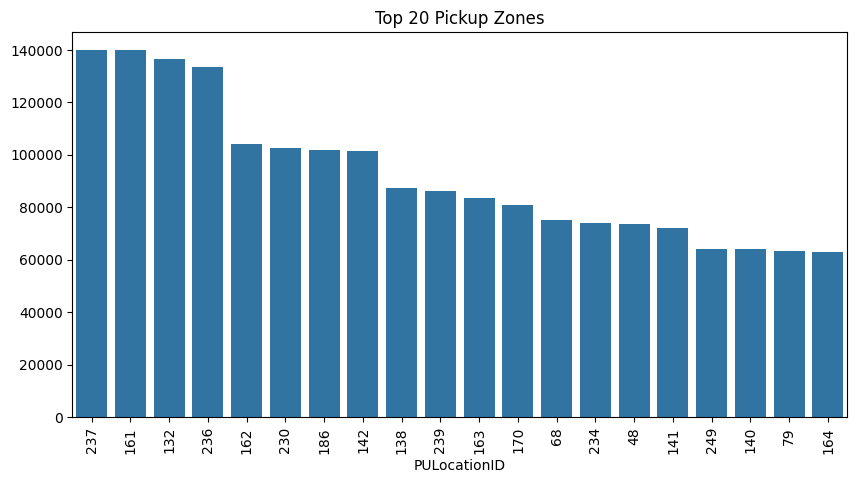

In [ ]:
pu_counts = df["PULocationID"].value_counts().head(20)

plt.figure(figsize=(10,5))
sns.barplot(x=pu_counts.index.astype(str), y=pu_counts.values)
plt.xticks(rotation=90)
plt.title("Top 20 Pickup Zones")
plt.show()

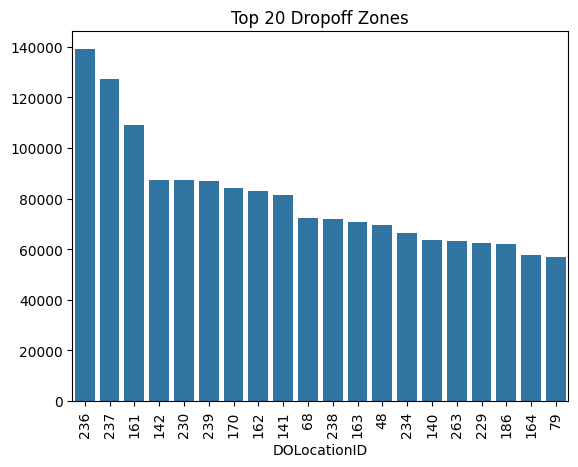

In [ ]:
do_counts = df["DOLocationID"].value_counts().head(20)
sns.barplot(x=do_counts.index.astype(str), y=do_counts.values)
plt.xticks(rotation=90)
plt.title("Top 20 Dropoff Zones")
plt.show()

# OD Pair EDA（Origin → Destination）

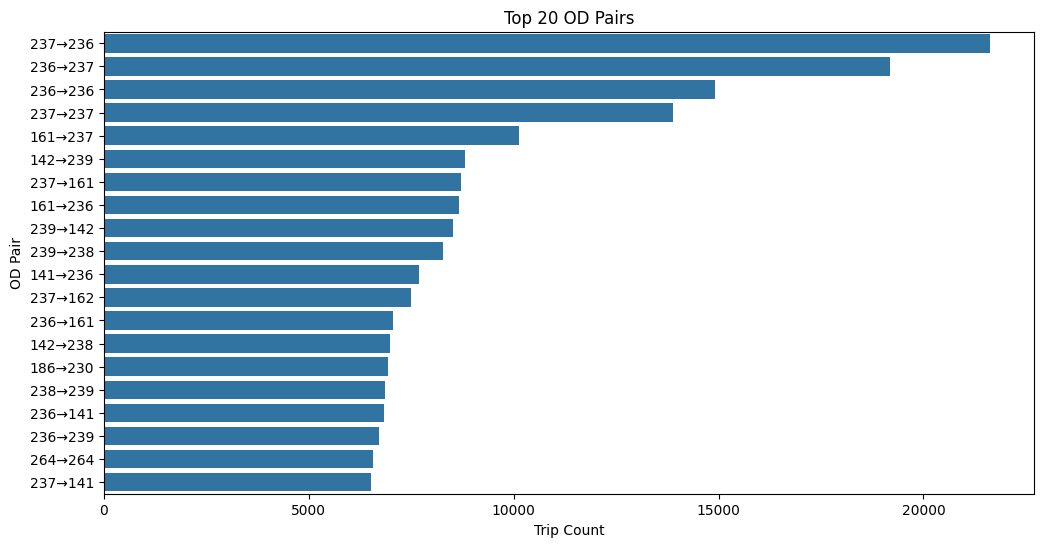

In [ ]:
df["OD_pair"] = df["PULocationID"].astype(str) + "→" + df["DOLocationID"].astype(str)
od_counts = df["OD_pair"].value_counts().head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=od_counts.values, y=od_counts.index)
plt.title("Top 20 OD Pairs")
plt.xlabel("Trip Count")
plt.ylabel("OD Pair")
plt.show()


# Trip Quality EDA

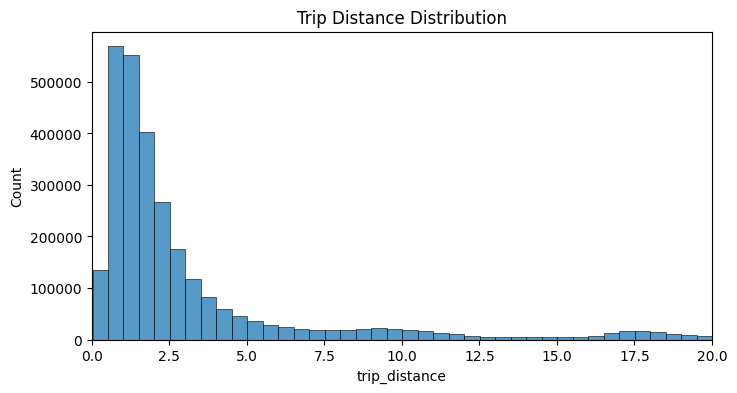

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df["trip_distance"], bins=100)
plt.xlim(0,20)
plt.title("Trip Distance Distribution")
plt.show()


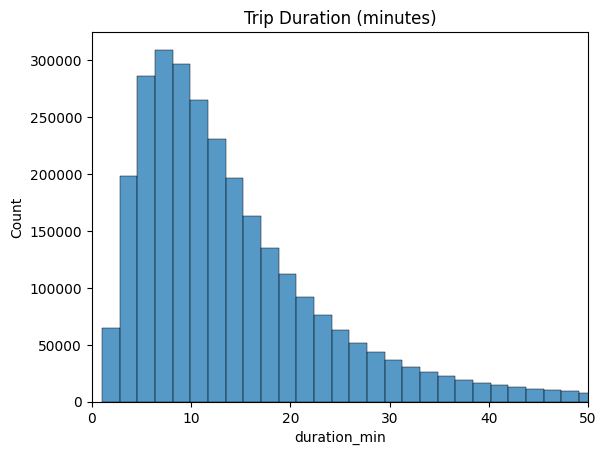

In [ ]:
df["duration_min"] = (df["dropoff_datetime"] - df["pickup_datetime"]).dt.total_seconds() / 60

sns.histplot(df["duration_min"], bins=100)
plt.xlim(0,50)
plt.title("Trip Duration (minutes)")
plt.show()


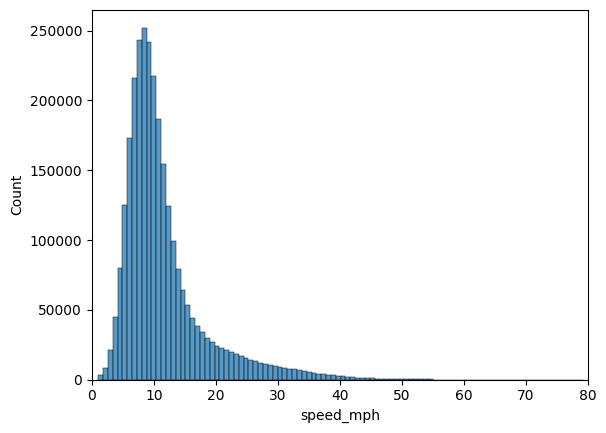

In [ ]:
df["speed_mph"] = df["trip_distance"] / (df["duration_min"] / 60)
sns.histplot(df["speed_mph"], bins=100)
plt.xlim(0,80)
plt.show()


# 费用 EDA

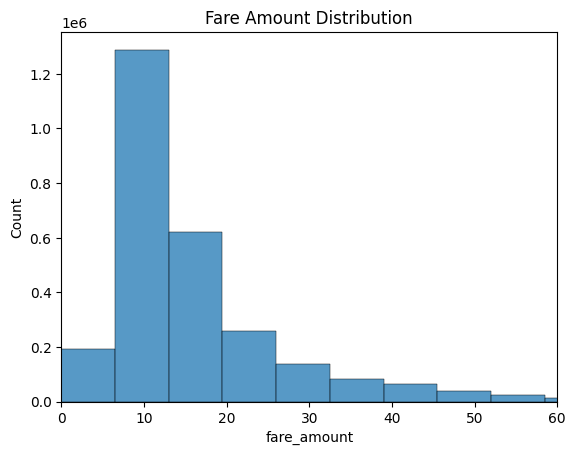

In [ ]:
sns.histplot(df["fare_amount"], bins=100)
plt.xlim(0,60)
plt.title("Fare Amount Distribution")
plt.show()


# 时空需求（核心任务）EDA
Insight： 不同区域 demand 模式不同 → 是采用 GCN-LSTM 的理论基础。

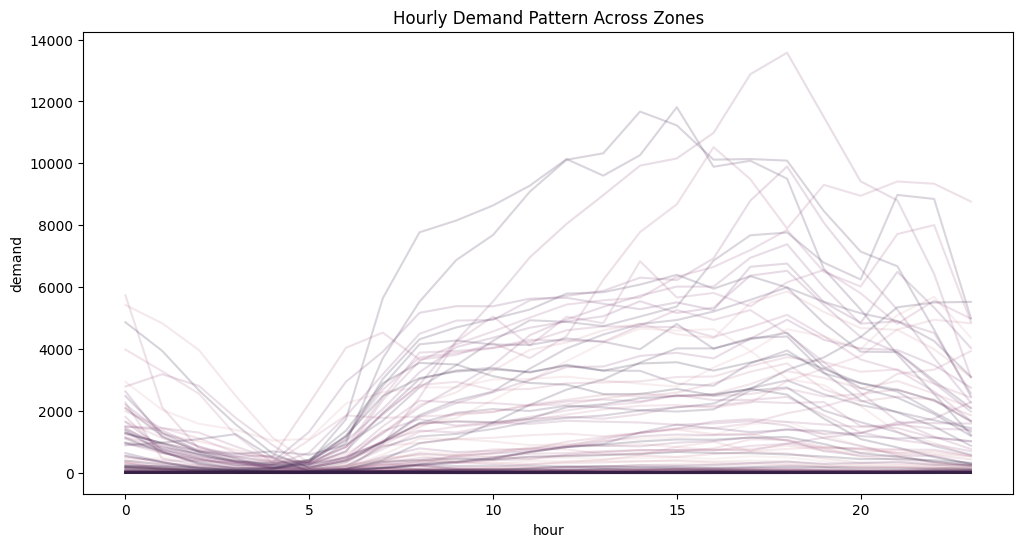

In [ ]:
zone_hour = df.groupby(["PULocationID", "hour"]).size().reset_index(name="demand")

plt.figure(figsize=(12,6))
sns.lineplot(data=zone_hour, x="hour", y="demand", hue="PULocationID", legend=False, alpha=0.2)
plt.title("Hourly Demand Pattern Across Zones")
plt.show()


Step 1 — 构建 Demand Time Series（按区域 + 时间）

你的模型（MA / XGBoost / GCN-LSTM）全部都是基于：demand(PU_zone, time_bin)

In [ ]:
df["time_bin"] = df["pickup_datetime"].dt.floor("1H")

In [ ]:
demand_ts = (
    df.groupby(["PULocationID", "time_bin"])
      .size()
      .reset_index(name="demand")
)

In [ ]:
df["pickup_datetime"].min(), df["pickup_datetime"].max()

(Timestamp('2024-01-01 00:00:00'), Timestamp('2024-02-01 00:01:15'))

In [ ]:
# 生成完整的时间序列（填补没有 trip 的 hour）
full_time_range = pd.date_range(
    start=demand_ts["time_bin"].min(),
    end=demand_ts["time_bin"].max(),
    freq="1H"
)

zones = df["PULocationID"].unique()

# 建立完整网格
grid = pd.MultiIndex.from_product(
    [zones, full_time_range],
    names=["PULocationID", "time_bin"]
)

demand_full = (
    demand_ts.set_index(["PULocationID", "time_bin"])
             .reindex(grid, fill_value=0)
             .reset_index()
)


In [76]:
# 计算缺失的时间段数量
original_count = len(demand_ts)
full_grid_count = len(grid)  # 区域数 × 时间点数
missing_count = full_grid_count - original_count

print(f"原始数据点数: {original_count}")
print(f"完整网格点数: {full_grid_count}")
print(f"缺失的时间段数量: {missing_count}")
print(f"缺失比例: {missing_count/full_grid_count*100:.2f}%")

原始数据点数: 73095
完整网格点数: 190720
缺失的时间段数量: 117625
缺失比例: 61.67%


Step 2 — 加入 Temporal Features

In [ ]:
demand_full["hour"] = demand_full["time_bin"].dt.hour
demand_full["weekday"] = demand_full["time_bin"].dt.dayofweek
demand_full["month"] = demand_full["time_bin"].dt.month

Step3——加入holiday

In [ ]:
%pip install holidays

In [ ]:
import holidays

demand_full["date"] = demand_full["time_bin"].dt.tz_localize(None).dt.normalize()

start_year = demand_full['date'].min().year
end_year = demand_full['date'].max().year

us_holidays = holidays.UnitedStates(years=range(start_year, end_year + 1))

demand_full["is_holiday"] = demand_full["date"].apply(lambda x: x in us_holidays).astype(int)

In [ ]:
demand_full["is_holiday"].value_counts()

,count
is_holiday,
0,178432
1,12288


In [78]:
demand_full.head(100)

,PULocationID,time_bin,demand,hour,weekday,month,date,is_holiday
0,186,2024-01-01 00:00:00,101,0,0,1,2024-01-01,1
1,186,2024-01-01 01:00:00,101,1,0,1,2024-01-01,1
2,186,2024-01-01 02:00:00,83,2,0,1,2024-01-01,1
3,186,2024-01-01 03:00:00,148,3,0,1,2024-01-01,1
4,186,2024-01-01 04:00:00,63,4,0,1,2024-01-01,1
...,...,...,...,...,...,...,...,...
95,186,2024-01-04 23:00:00,125,23,3,1,2024-01-04,0
96,186,2024-01-05 00:00:00,60,0,4,1,2024-01-05,0
97,186,2024-01-05 01:00:00,37,1,4,1,2024-01-05,0
98,186,2024-01-05 02:00:00,15,2,4,1,2024-01-05,0


# 聚合天气数据

In [ ]:
%pip install meteostat

In [ ]:
# 获取 NYC Central Park（站点ID：72506） 的逐小时天气数据
from meteostat import Hourly, Stations
import pandas as pd
from datetime import datetime

# 定义 NYC 时间范围
start = df["pickup_datetime"].min()
end = df["pickup_datetime"].max()

# 搜索纽约最近的气象站（中央公园）
stations = Stations()
stations = stations.nearby(40.7812, -73.9665)  # Central Park坐标
station = stations.fetch(1).iloc[0]
station


,KNYC0
name,New York City / Yorkville
country,US
region,NY
wmo,<NA>
icao,KNYC
latitude,40.7789
longitude,-73.9692
elevation,3.0
timezone,America/New_York
hourly_start,1943-12-01 00:00:00


In [ ]:
df["pickup_datetime"].min(), df["pickup_datetime"].max()

(Timestamp('2024-01-01 00:00:00'), Timestamp('2024-02-01 00:01:15'))

In [ ]:
# Download hourly weather data - Fixed version
from meteostat import Point, Hourly
import pandas as pd

# Step 1: Define time range (based on your taxi data)
start = df["pickup_datetime"].min()
end = df["pickup_datetime"].max()

print(f"Fetching weather data for time range: {start} to {end}")

# Step 2: Use Point API to get hourly weather for NYC coordinates
nyc = Point(40.7128, -74.0060, 10)  # NYC coordinates (lat, lon, altitude)
weather = Hourly(nyc, start, end, timezone='America/New_York')

# Step 3: Fetch the data
weather_data = weather.fetch()

print(f"Weather data shape: {weather_data.shape}")

# Step 4: Reset index and rename time column
weather_data = weather_data.reset_index().rename(columns={"time": "time_bin"})
# time zone
weather_data['time_bin'] = weather_data['time_bin'].dt.tz_localize(None)


print("Weather data sample:")
print(weather_data.head())

print(f"Temperature data coverage: {weather_data['temp'].notna().sum()}/{len(weather_data)} rows")

Fetching weather data for time range: 2024-01-01 00:00:00 to 2024-02-01 00:01:15
Weather data shape: (745, 11)
Weather data sample:
             time_bin  temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  \
0 2024-01-01 00:00:00   5.6  -0.7  64.0   0.0  <NA>  250.0  14.8  <NA>   
1 2024-01-01 01:00:00   5.6  -0.7  64.0   0.0  <NA>  260.0  14.8  <NA>   
2 2024-01-01 02:00:00   5.6  -0.7  64.0   0.0  <NA>  270.0  11.2  <NA>   
3 2024-01-01 03:00:00   5.0  -0.6  67.0   0.0  <NA>  260.0  11.2  <NA>   
4 2024-01-01 04:00:00   5.0  -1.0  65.0   0.0  <NA>  250.0   7.6  <NA>   

     pres  tsun  coco  
0  1016.7  <NA>   3.0  
1  1016.4  <NA>   3.0  
2  1016.2  <NA>   3.0  
3  1016.2  <NA>   3.0  
4  1015.8  <NA>   3.0  
Temperature data coverage: 745/745 rows


In [ ]:
drop_cols = ["snow", "tsun", "wpgt", "coco"]
weather_data = weather_data.drop(columns=drop_cols, errors="ignore")

In [ ]:
# Check missing data
print("\nMissing weather data:")
for col in weather_data.columns.tolist():
    missing_pct = weather_data[col].isna().mean() * 100
    print(f"{col}: {missing_pct:.1f}%")



Missing weather data:
time_bin: 0.0%
temp: 0.0%
dwpt: 0.0%
rhum: 0.0%
prcp: 0.0%
wdir: 0.0%
wspd: 0.0%
pres: 0.0%


In [ ]:
# Merge datasets
demand_weather = demand_full.merge(weather_data, on="time_bin", how="left")

In [ ]:
print(demand_weather.columns)

Index(['PULocationID', 'time_bin', 'demand', 'hour', 'weekday', 'month',
       'date', 'is_holiday', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd',
       'pres'],
      dtype='object')


In [ ]:
demand_weather

,PULocationID,time_bin,demand,hour,weekday,month,date,is_holiday,temp,dwpt,rhum,prcp,wdir,wspd,pres
0,186,2024-01-01 00:00:00,101,0,0,1,2024-01-01,1,5.6,-0.7,64.0,0.0,250.0,14.8,1016.7
1,186,2024-01-01 01:00:00,101,1,0,1,2024-01-01,1,5.6,-0.7,64.0,0.0,260.0,14.8,1016.4
2,186,2024-01-01 02:00:00,83,2,0,1,2024-01-01,1,5.6,-0.7,64.0,0.0,270.0,11.2,1016.2
3,186,2024-01-01 03:00:00,148,3,0,1,2024-01-01,1,5.0,-0.6,67.0,0.0,260.0,11.2,1016.2
4,186,2024-01-01 04:00:00,63,4,0,1,2024-01-01,1,5.0,-1.0,65.0,0.0,250.0,7.6,1015.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190715,109,2024-01-31 20:00:00,0,20,2,1,2024-01-31,0,3.3,-0.5,76.0,0.0,250.0,5.4,1019.3
190716,109,2024-01-31 21:00:00,0,21,2,1,2024-01-31,0,3.3,-0.5,76.0,0.0,250.0,5.4,1019.1
190717,109,2024-01-31 22:00:00,0,22,2,1,2024-01-31,0,2.8,-0.0,82.0,0.0,260.0,5.4,1019.1
190718,109,2024-01-31 23:00:00,0,23,2,1,2024-01-31,0,2.8,-0.0,82.0,0.0,230.0,7.6,1019.3


In [79]:
demand_weather.to_csv('demand_weather.csv', index=False)

# 展示Location 分布

In [ ]:
%pip install geopandas

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# 读取 zones CSV
zones = pd.read_csv("NYC_Taxi_Zones_20251119.csv")

zones = zones.rename(columns={
    'Shape Geometry': 'geometry',
    'Location ID': 'LocationID',
    'Zone': 'zone',
    'Borough': 'borough'
})

# 使用 from_wkt 解析 MULTIPOLYGON
zones['geometry'] = gpd.GeoSeries.from_wkt(zones['geometry'])

# 转成 GeoDataFrame
gdf = gpd.GeoDataFrame(zones, geometry='geometry', crs="EPSG:4326")

print(gdf.head())


                                            geometry  Shape Length  \
0  MULTIPOLYGON (((-74.18445 40.695, -74.18449 40...      0.116357   
1  MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...      0.433470   
2  MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ...      0.084341   
3  MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ...      0.043567   
4  MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ...      0.092146   

   Shape Area                     zone  LocationID        borough  
0    0.000782           Newark Airport           1            EWR  
1    0.004866              Jamaica Bay           2         Queens  
2    0.000314  Allerton/Pelham Gardens           3          Bronx  
3    0.000112            Alphabet City           4      Manhattan  
4    0.000498            Arden Heights           5  Staten Island  


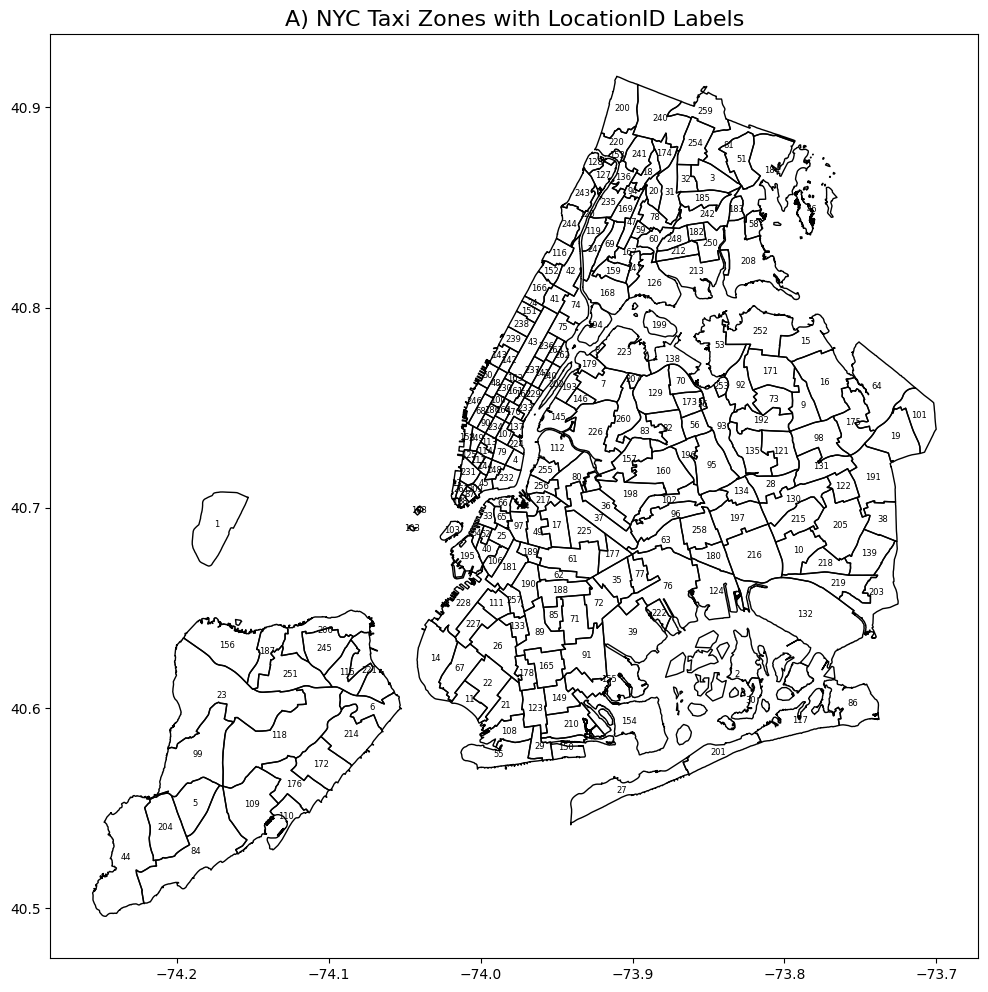

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))

# 绘制区域边界
gdf.plot(ax=ax, edgecolor='black', facecolor='none')

# 添加标题
ax.set_title("A) NYC Taxi Zones with LocationID Labels", fontsize=16)

# 计算每个区域的质心用于放置文字
gdf['centroid'] = gdf.geometry.centroid

# 标注每个 LocationID
for idx, row in gdf.iterrows():
    x = row['centroid'].x
    y = row['centroid'].y
    ax.text(
        x, y,
        str(row['LocationID']),
        fontsize=6,
        ha='center',
        va='center'
    )

plt.show()

In [ ]:
import pandas as pd


avg_demand = demand_weather.groupby('PULocationID')['demand'].mean().reset_index()
avg_demand = avg_demand.rename(columns={
    'PULocationID': 'LocationID',
    'demand': 'avg_demand'
})

avg_demand.head()

,LocationID,avg_demand
0,1,0.018792
1,2,0.004027
2,3,0.106040
3,4,4.336913
4,6,0.009396


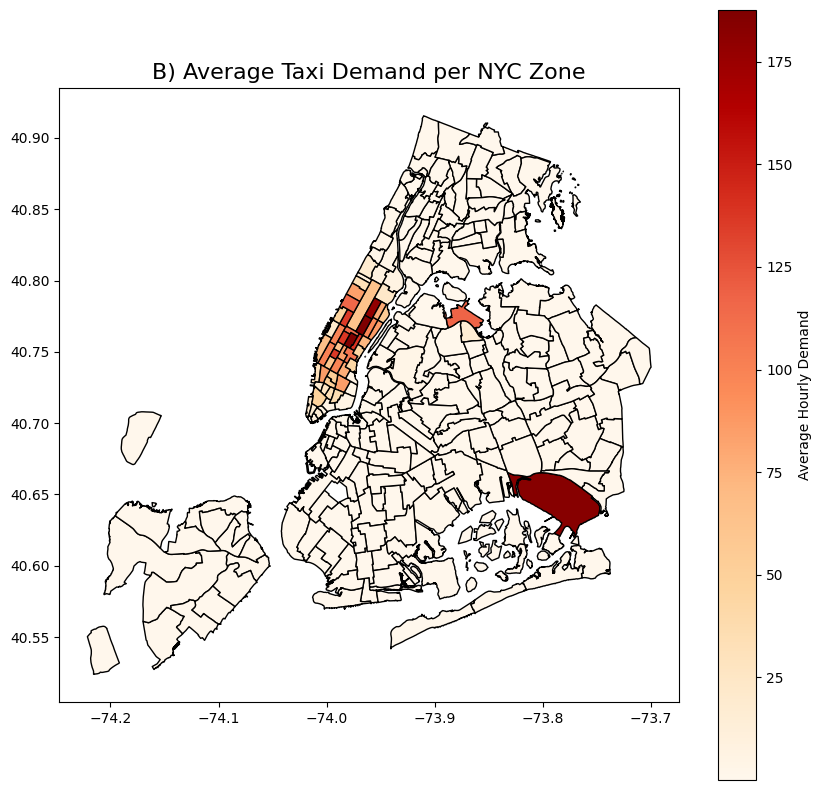

In [ ]:
# 合并区域边界 + 需求
merged = gdf.merge(avg_demand, on='LocationID', how='left')

# 绘制热力图
fig, ax = plt.subplots(figsize=(10, 10))
merged.plot(
    column='avg_demand',
    ax=ax,
    cmap='OrRd',
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Average Hourly Demand"},
)
ax.set_title("B) Average Taxi Demand per NYC Zone", fontsize=16)
plt.show()

#2025 data preparation

In [85]:
# Load 2025 data for prediction validation
print("\n" + "="*60)
print("LOADING 2025 DATA FOR CROSS-YEAR PREDICTION VALIDATION")
print("="*60)

# Load 2025 January data
tripdata_2025 = pd.read_parquet('/content/yellow_tripdata_2025-01.parquet')
print(f"2025 data shape: {tripdata_2025.shape}")

# Process 2025 data same as 2024 data
df_2025 = tripdata_2025.copy()

# Time format processing for 2025
df_2025["pickup_datetime"] = pd.to_datetime(df_2025["tpep_pickup_datetime"])
df_2025["dropoff_datetime"] = pd.to_datetime(df_2025["tpep_dropoff_datetime"])

# Data cleaning for 2025 (same as 2024)
print(f"Original 2025 data rows: {len(df_2025)}")

# Filter out data before January 1, 2025
start_date_2025 = pd.Timestamp('2025-01-01')
df_2025 = df_2025[df_2025['tpep_pickup_datetime'] >= start_date_2025].copy()

print(f"Cleaned 2025 data rows: {len(df_2025)}")

# Fill NaN with default values (same cleaning as 2024)
df_2025["passenger_count"] = df_2025["passenger_count"].fillna(1)
df_2025["congestion_surcharge"] = df_2025["congestion_surcharge"].fillna(0)
df_2025["Airport_fee"] = df_2025["Airport_fee"].fillna(0)

# Drop columns that are useless for forecasting
df_2025 = df_2025.drop(columns=["RatecodeID", "store_and_fwd_flag"], errors='ignore')

# Anomaly detection and cleaning (same as 2024)
df_2025 = df_2025[(df_2025["trip_distance"] > 0) & (df_2025["trip_distance"] <= 50)]

df_2025["duration_min"] = (df_2025["tpep_dropoff_datetime"] - df_2025["tpep_pickup_datetime"]).dt.total_seconds() / 60
df_2025 = df_2025[(df_2025["duration_min"] > 1) & (df_2025["duration_min"] <= 180)]

df_2025["speed_mph"] = df_2025["trip_distance"] / (df_2025["duration_min"] / 60)
df_2025 = df_2025[(df_2025["speed_mph"] > 1) & (df_2025["speed_mph"] <= 80)]

# Check negative values in fare columns
fare_cols = ["fare_amount","extra","mta_tax","tip_amount",
             "tolls_amount","improvement_surcharge","total_amount"]

for col in fare_cols:
    if col in df_2025.columns:
        df_2025 = df_2025[df_2025[col] >= 0]

df_2025 = df_2025[df_2025["total_amount"] >= df_2025["fare_amount"]]

print(f"Final cleaned 2025 data rows: {len(df_2025)}")

# Create 2025 demand time series
df_2025["time_bin"] = df_2025["pickup_datetime"].dt.floor("1H")

demand_ts_2025 = (
    df_2025.groupby(["PULocationID", "time_bin"])
      .size()
      .reset_index(name="demand")
)

# Generate complete time series for 2025 (fill missing hours with 0)
full_time_range_2025 = pd.date_range(
    start=demand_ts_2025["time_bin"].min(),
    end=demand_ts_2025["time_bin"].max(),
    freq="1H"
)

zones_2025 = df_2025["PULocationID"].unique()

# Find common zones between 2024 and 2025 for fair comparison
zones_2024 = demand_weather["PULocationID"].unique()
common_zones = list(set(zones_2024) & set(zones_2025))

print(f"2024 zones: {len(zones_2024)}, 2025 zones: {len(zones_2025)}")
print(f"Common zones for comparison: {len(common_zones)}")

# Build complete grid for 2025
grid_2025 = pd.MultiIndex.from_product(
    [common_zones, full_time_range_2025],
    names=["PULocationID", "time_bin"]
)

demand_full_2025 = (
    demand_ts_2025[demand_ts_2025["PULocationID"].isin(common_zones)]
    .set_index(["PULocationID", "time_bin"])
    .reindex(grid_2025, fill_value=0)
    .reset_index()
)

print(f"2025 complete demand grid shape: {demand_full_2025.shape}")


LOADING 2025 DATA FOR CROSS-YEAR PREDICTION VALIDATION
2025 data shape: (3475226, 20)
Original 2025 data rows: 3475226
Cleaned 2025 data rows: 3475205
Final cleaned 2025 data rows: 3231146
2024 zones: 256, 2025 zones: 259
Common zones for comparison: 255
2025 complete demand grid shape: (189975, 3)


# Simple Weighted Moving Average for Demand Prediction

In [86]:
"""# Simple Weighted Moving Average for Demand Prediction"""

tripdata_2025 = pd.read_parquet('yellow_tripdata_2025-01.parquet')

def weighted_moving_average_demand_cross_year(train_data_2024, target_data_2025, window_size=2):
    """
    Cross-year prediction: Use 2024 data patterns to predict 2025 demand
    Similar to original approach: 2015 → 2016 prediction

    Parameters:
    - train_data_2024: 2024 demand data for training patterns
    - target_data_2025: 2025 actual data for validation
    - window_size: Moving average window (default=2)

    Returns:
    - results_df: Predictions vs actual for 2025
    - mape, mse: Performance metrics
    """

    print("Computing cross-year prediction ratios...")

    # Calculate demand ratios between corresponding time periods
    # Group by location for ratio calculation
    results_list = []

    for location_id in train_data_2024['PULocationID'].unique():
        # Get 2024 data for this location
        loc_2024 = train_data_2024[train_data_2024['PULocationID'] == location_id].copy()
        loc_2024 = loc_2024.sort_values('time_bin').reset_index(drop=True)

        # Get 2025 data for this location
        loc_2025 = target_data_2025[target_data_2025['PULocationID'] == location_id].copy()
        loc_2025 = loc_2025.sort_values('time_bin').reset_index(drop=True)

        if len(loc_2024) == 0 or len(loc_2025) == 0:
            continue

        # Align time periods (assume same number of hours in month)
        min_length = min(len(loc_2024), len(loc_2025))

        demand_2024 = loc_2024['demand'].values[:min_length]
        demand_2025_actual = loc_2025['demand'].values[:min_length]
        time_2025 = loc_2025['time_bin'].values[:min_length]

        # Calculate ratio: 2025_demand / 2024_demand (avoid division by zero)
        ratios = []
        for i in range(min_length):
            if demand_2024[i] > 0:
                ratio = demand_2025_actual[i] / demand_2024[i]
            else:
                ratio = 1.0 if demand_2025_actual[i] == 0 else 2.0  # Default ratios
            ratios.append(ratio)

        # Apply weighted moving average to ratios for prediction
        predicted_ratios = []
        predicted_demands = []
        abs_errors = []
        sq_errors = []

        # Start with first ratio
        if len(ratios) > 0:
            predicted_ratio = ratios[0]

        for i in range(min_length):
            # Store current prediction
            predicted_ratios.append(predicted_ratio)
            predicted_demand = predicted_ratio * demand_2024[i]
            predicted_demands.append(predicted_demand)

            # Calculate errors against actual 2025 demand
            abs_error = abs(predicted_demand - demand_2025_actual[i])
            abs_errors.append(abs_error)
            sq_errors.append(abs_error ** 2)

            # Calculate next prediction ratio using weighted moving average
            if i + 1 >= window_size:
                # Use full window with weights [2, 1] for window_size=2
                sum_ratios = 0
                sum_weights = 0
                for j in range(window_size, 0, -1):
                    weight = j
                    ratio_val = ratios[i - window_size + j]
                    sum_ratios += weight * ratio_val
                    sum_weights += weight
                predicted_ratio = sum_ratios / sum_weights
            elif i + 1 > 0:
                # Use partial window for early predictions
                sum_ratios = 0
                sum_weights = 0
                for j in range(i + 1, 0, -1):
                    weight = j
                    ratio_val = ratios[j - 1]
                    sum_ratios += weight * ratio_val
                    sum_weights += weight
                predicted_ratio = sum_ratios / sum_weights

        # Store results for this location
        for i in range(min_length):
            results_list.append({
                'PULocationID': location_id,
                'time_bin': time_2025[i],
                'demand_2024': demand_2024[i],
                'actual_demand_2025': demand_2025_actual[i],
                'predicted_demand_2025': predicted_demands[i],
                'ratio_2025_2024': ratios[i],
                'predicted_ratio': predicted_ratios[i],
                'absolute_error': abs_errors[i],
                'squared_error': sq_errors[i]
            })

    # Create results DataFrame
    results_df = pd.DataFrame(results_list)

    if len(results_df) == 0:
        print("No valid predictions generated!")
        return pd.DataFrame(), float('inf'), float('inf')

    # Calculate overall performance metrics
    total_actual = results_df['actual_demand_2025'].sum()
    if total_actual > 0:
        mape = results_df['absolute_error'].sum() / len(results_df) / (total_actual / len(results_df))
    else:
        mape = float('inf')

    mse = results_df['squared_error'].mean()
    mae = results_df['absolute_error'].mean()

    print(f"\nCross-Year Prediction Results (2024 → 2025):")
    print(f"MAPE: {mape:.4f} ({mape*100:.2f}%)")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.2f}")
    print(f"Total predictions: {len(results_df)}")

    return results_df, mape, mse



RUNNING CROSS-YEAR PREDICTION: 2024 → 2025
Training data (2024) shape: (189975, 3)
Training date range: 2024-01-01 00:00:00 to 2024-02-01 00:00:00
Target data (2025) shape: (189975, 3)
Target date range: 2025-01-01 00:00:00 to 2025-02-01 00:00:00
Computing cross-year prediction ratios...

Cross-Year Prediction Results (2024 → 2025):
MAPE: 0.3220 (32.20%)
MSE: 399.3276
MAE: 5.48
Total predictions: 189975

Top 10 Locations Performance:
              avg_demand  total_demand    mae   rmse
PULocationID                                        
161               215.48        160529  43.11  72.53
237               211.29        157409  40.35  70.16
236               200.24        149180  42.14  82.13
132               178.66        133104  46.40  73.92
230               157.99        117703  41.20  71.73
186               152.65        113723  57.63  92.57
162               150.46        112092  32.42  47.85
142               141.83        105667  46.35  84.55
239               122.81       

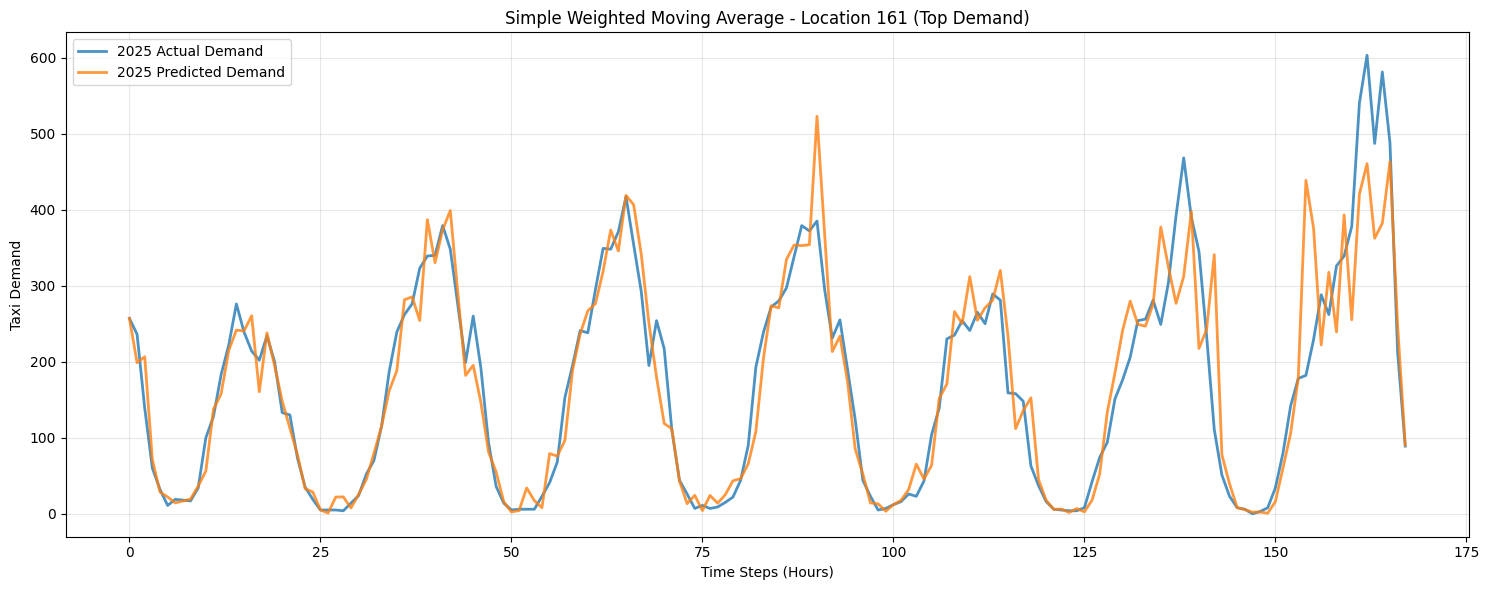

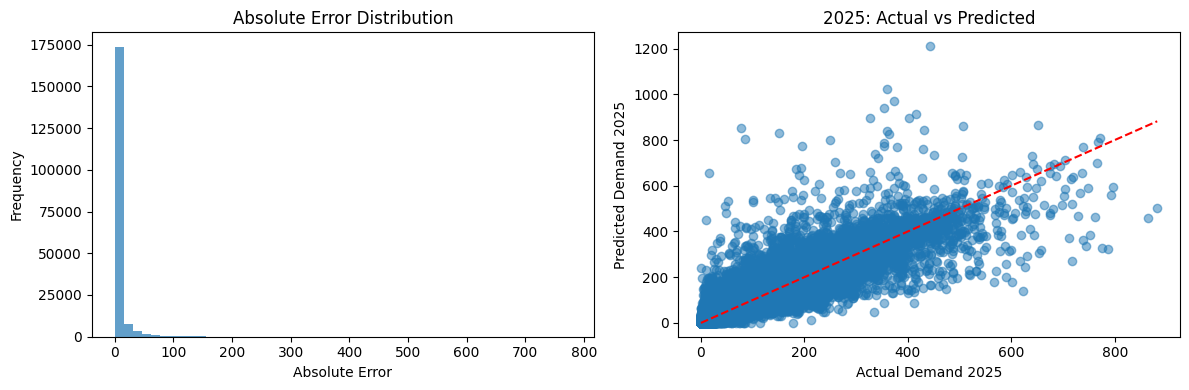


Top 10 Locations Performance (2024 → 2025 Prediction):
              avg_demand_2025  total_demand_2025    mae   rmse
PULocationID                                                  
161                    215.48             160529  43.11  72.53
237                    211.29             157409  40.35  70.16
236                    200.24             149180  42.14  82.13
132                    178.66             133104  46.40  73.92
230                    157.99             117703  41.20  71.73
186                    152.65             113723  57.63  92.57
162                    150.46             112092  32.42  47.85
142                    141.83             105667  46.35  84.55
239                    122.81              91495  29.44  48.23
163                    122.39              91180  25.19  37.81

Demand Growth Analysis (Top 5 locations):
LocationID | 2024_Total | 2025_Actual | 2025_Predicted | Actual_Growth% | Predicted_Growth%
-----------------------------------------------------

In [88]:
# Apply Simple Weighted Moving Average: 2024 → 2025 Prediction
print("\n" + "="*60)
print("RUNNING CROSS-YEAR PREDICTION: 2024 → 2025")
print("="*60)

# Prepare training data (2024) - filter to common zones
demand_2024_train = demand_weather[
    demand_weather["PULocationID"].isin(common_zones)
][['PULocationID', 'time_bin', 'demand']].copy()

print(f"Training data (2024) shape: {demand_2024_train.shape}")
print(f"Training date range: {demand_2024_train['time_bin'].min()} to {demand_2024_train['time_bin'].max()}")

# Prepare prediction target (2025)
demand_2025_target = demand_full_2025[['PULocationID', 'time_bin', 'demand']].copy()

print(f"Target data (2025) shape: {demand_2025_target.shape}")
print(f"Target date range: {demand_2025_target['time_bin'].min()} to {demand_2025_target['time_bin'].max()}")

# Run cross-year prediction using 2024 patterns to predict 2025
ma_results, ma_mape, ma_mse = weighted_moving_average_demand_cross_year(demand_2024_train, demand_2025_target)

# Display top locations by demand
location_performance = ma_results.groupby('PULocationID').agg({
    'actual_demand_2025': ['mean', 'sum'],
    'absolute_error': 'mean',
    'squared_error': lambda x: np.sqrt(x.mean())  # RMSE
}).round(2)

location_performance.columns = ['avg_demand', 'total_demand', 'mae', 'rmse']
location_performance = location_performance.sort_values('total_demand', ascending=False)

print(f"\nTop 10 Locations Performance:")
print(location_performance.head(10))

# Visualize results for top location
top_location = location_performance.index[0]
top_location_data = ma_results[ma_results['PULocationID'] == top_location].head(168)  # One week

plt.figure(figsize=(15, 6))
plt.plot(range(len(top_location_data)), top_location_data['actual_demand_2025'],
         label='2025 Actual Demand', linewidth=2, alpha=0.8)
plt.plot(range(len(top_location_data)), top_location_data['predicted_demand_2025'],
         label='2025 Predicted Demand', linewidth=2, alpha=0.8)

plt.title(f'Simple Weighted Moving Average - Location {top_location} (Top Demand)')
plt.xlabel('Time Steps (Hours)')
plt.ylabel('Taxi Demand')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Error distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(ma_results['absolute_error'], bins=50, alpha=0.7)
plt.title('Absolute Error Distribution')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.scatter(ma_results['actual_demand_2025'], ma_results['predicted_demand_2025'], alpha=0.5)
plt.plot([0, ma_results['actual_demand_2025'].max()], [0, ma_results['actual_demand_2025'].max()], 'r--')
plt.title('2025: Actual vs Predicted')
plt.xlabel('Actual Demand 2025')
plt.ylabel('Predicted Demand 2025')

plt.tight_layout()
plt.show()

# Display top locations performance summary
location_performance = ma_results.groupby('PULocationID').agg({
    'actual_demand_2025': ['mean', 'sum'],
    'absolute_error': 'mean',
    'squared_error': lambda x: np.sqrt(x.mean())  # RMSE
}).round(2)

location_performance.columns = ['avg_demand_2025', 'total_demand_2025', 'mae', 'rmse']
location_performance = location_performance.sort_values('total_demand_2025', ascending=False)

print(f"\nTop 10 Locations Performance (2024 → 2025 Prediction):")
print(location_performance.head(10))

# Compare demand patterns: 2024 vs 2025
demand_comparison = ma_results.groupby('PULocationID').agg({
    'demand_2024': 'sum',
    'actual_demand_2025': 'sum',
    'predicted_demand_2025': 'sum'
}).round(0)

demand_comparison['growth_actual'] = ((demand_comparison['actual_demand_2025'] / demand_comparison['demand_2024']) - 1) * 100
demand_comparison['growth_predicted'] = ((demand_comparison['predicted_demand_2025'] / demand_comparison['demand_2024']) - 1) * 100
demand_comparison = demand_comparison.sort_values('actual_demand_2025', ascending=False)

print(f"\nDemand Growth Analysis (Top 5 locations):")
print("LocationID | 2024_Total | 2025_Actual | 2025_Predicted | Actual_Growth% | Predicted_Growth%")
print("-" * 90)
for idx, row in demand_comparison.head(5).iterrows():
    print(f"{idx:9} | {row['demand_2024']:10.0f} | {row['actual_demand_2025']:11.0f} | {row['predicted_demand_2025']:13.0f} | {row['growth_actual']:12.1f}% | {row['growth_predicted']:15.1f}%")

print(f"\nCross-Year Prediction Analysis Completed!")
print(f"Results saved in 'ma_results' DataFrame with {len(ma_results)} predictions")

# Save cross-year prediction results
ma_results.to_csv('cross_year_prediction_results_2024_2025.csv', index=False)
demand_comparison.to_csv('demand_growth_analysis_2024_2025.csv')

print(f"Results saved to:")
print(f"  - 'cross_year_prediction_results_2024_2025.csv'")
print(f"  - 'demand_growth_analysis_2024_2025.csv'")
